In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sys
sys.path.append('../')
from game.Bankgames import *
from game.plotting import *
from game.distributions import TruncatedGaussian, Uniform, PiecewiseUniform
import nashpy as nh
from tqdm import tqdm

In [2]:
truncGausCases = search_eps_signs(dist = 'truncated_gaussian')
for sign_pair, examples in truncGausCases.items():
    print(f'{sign_pair}: {len(examples)} cases found')


(np.float64(-1.0), np.float64(-1.0)): 173 cases found
(np.float64(1.0), np.float64(-1.0)): 28 cases found
(np.float64(1.0), np.float64(1.0)): 24 cases found


In [3]:
piecewiseUniformCases = search_eps_signs(dist = 'piecewise_uniform')
for sign_pair, examples in piecewiseUniformCases.items():
    print(f'{sign_pair}: {len(examples)} cases found')

10000it [00:40, 246.48it/s]

(np.float64(-1.0), np.float64(-1.0)): 4 cases found
(np.float64(-1.0), np.float64(1.0)): 4 cases found
(np.float64(1.0), np.float64(1.0)): 4 cases found


In [4]:
# gamma_l, gamma_h = 0.-0, 0.4
# puf = PiecewiseUniform(ga_l = gamma_l, ga_h = gamma_h)
# taus = sorted([1 / (2 + gamma) for gamma in [gamma_l, gamma_h]])
# g2 = GameTrueMatrix2by2(gammas=[gamma_l, gamma_h], taus=taus, dist=puf)
# print(g2.eps1,g2.eps2)


# gamma_l, gamma_h = 0.01, 0.06
# puf = PiecewiseUniform(ga_l = gamma_l, ga_h = gamma_h)
# taus = sorted([1 / (2 + gamma) for gamma in [gamma_l, gamma_h]])
# g2 = GameTrueMatrix2by2(gammas=[gamma_l, gamma_h], taus=taus, dist=puf)
# print(g2.eps1,g2.eps2)



# gamma_l, gamma_h = 0.01, 0.11
# puf = PiecewiseUniform(ga_l = gamma_l, ga_h = gamma_h)
# taus = sorted([1 / (2 + gamma) for gamma in [gamma_l, gamma_h]])
# g2 = GameTrueMatrix2by2(gammas=[gamma_l, gamma_h], taus=taus, dist=puf)
# print(g2.eps1,g2.eps2)

In [6]:
# constructed to find the fourth case epsilon_1<0 and epsilon_2 >0
gammas = sorted([0.3, 0.5])
taus = sorted([1/(2+gamma) for gamma in gammas])
puf = PiecewiseUniform(ga_l = gammas[0], ga_h = gammas[1]) #needs exactly these gamma_l and high values
gtm = GameTrueMatrix2by2(gammas=[0.3, 0.5], taus=taus, dist=puf)

gtm.eps1,gtm.eps2

(0.010521738689701018, 0.028304347826087026)

# PLOTS TODO n = 4 actions BELOW

1) Known Matrix, Full matrix known


Game with n = 4 actions (2 gammas) 
4 cases for epsilon_1, epsilon_2

Dynamics curves, show indifferent to initialization 

- epsilon_1>0, epsilon_2>0 ; 1 pure NE
- epsilon_1<0, epsilon_2<0 1 pure NE
- 3 cases for different signs (-,+)
- 3 cases for different signs (+, -)

---

1) Sampled Matrix (Fresh matrix estimated in each round) 

Game with n = 4 actions (2 gammas)
4 cases for epsilon_1, epsilon_2

Dynamics curves, show indifferent to initialization 

- 1 pure NE
- 1 pure NE
- 3 cases for different signs (-,+)
- 3 cases for different signs (+,-)
 
Fraction of convergence plots
- Fix distribution, fix gamma (defines an instance of the one-shot game)
- For a fixed initilaization, check convergence across randomness in sampling (fresh estimate for A)
- Fix distribution, fix gamma, for some fixed initilaization, check distance to NE across randomness in sampling (fresh estimate for A)


- For a fixed initilaization, check convergence check convergence across randomness in sampling (moving estimate for A)
- Fix distribution, fix gamma, for some fixed initilaization, check distance to NE across randomness in sampling (moving estimate for A)

# PLOTS TODO for larger number of actions

vary distribution (fix truncated gaussian some values)
precified values of gamma
vary initializations

## Case 1 : epsilon_1 > 0, epsilon_2 < 0, 
## 3 NE - 2 pure, 1 mixed

# Using truncgauss here

Three types of hedge dynamics curves
1) hedge on known matrix
2) hedge on fresh sampled each time
3) hedge on moving average

In [7]:
gammas = sorted([0.1, 0.8])
taus = sorted([1/(2+gamma) for gamma in gammas])
mu = 0.6
sigma = 0.2
tg = TruncatedGaussian(mu = mu, sigma = sigma)
gtm = GameTrueMatrix2by2(gammas=gammas, taus=taus, dist=tg)
print(gtm.eps1, gtm.eps2) # epsilon1 and epsilon2

0.033116954446247626 -0.12479184642812027


In [8]:
display(len(gtm.NE_theory), gtm.NE_theory) # this is what theory gives us
display(len(gtm.NE_se), gtm.NE_se) 
# this is from running nashpy directly on the utility matrices, note in nashpy row players strat i.e. B2 appears first

3

[[[0, 0, 1, 0], [0, 0, 1, 0]],
 [[0, 1, 0, 0], [0, 1, 0, 0]],
 [[0, 0.790277968910704, 0.209722031089296, 0],
  [0, 0.790277968910704, 0.209722031089296, 0]]]

3

[(array([0., 1., 0., 0.]), array([0., 1., 0., 0.])),
 (array([0., 0., 1., 0.]), array([0., 0., 1., 0.])),
 (array([0.        , 0.79027797, 0.20972203, 0.        ]),
  array([0.        , 0.79027797, 0.20972203, 0.        ]))]

In [9]:
# run hedge on known matrix
T = 5000
eta = 0.1
p_b1 = np.array([0., 0.4, 0.6, 0.])
p_b2 = np.array([0., 0.3, 0.7, 0.])

b1,b2,gammas,taus = gtm.run_hedge(T=T, p_b1=p_b1, p_b2=p_b2, eta=eta)
print(b1[-1], b2[-1]) 
# last iterates for Bank1 and Bank2; We end up going to action 3 for both banks i.e. tau_h, gammaa_l
# symmetric pure NE

[0.00000000e+00 1.00988273e-27 1.00000000e+00 0.00000000e+00] [0.00000000e+00 7.89645439e-28 1.00000000e+00 0.00000000e+00]


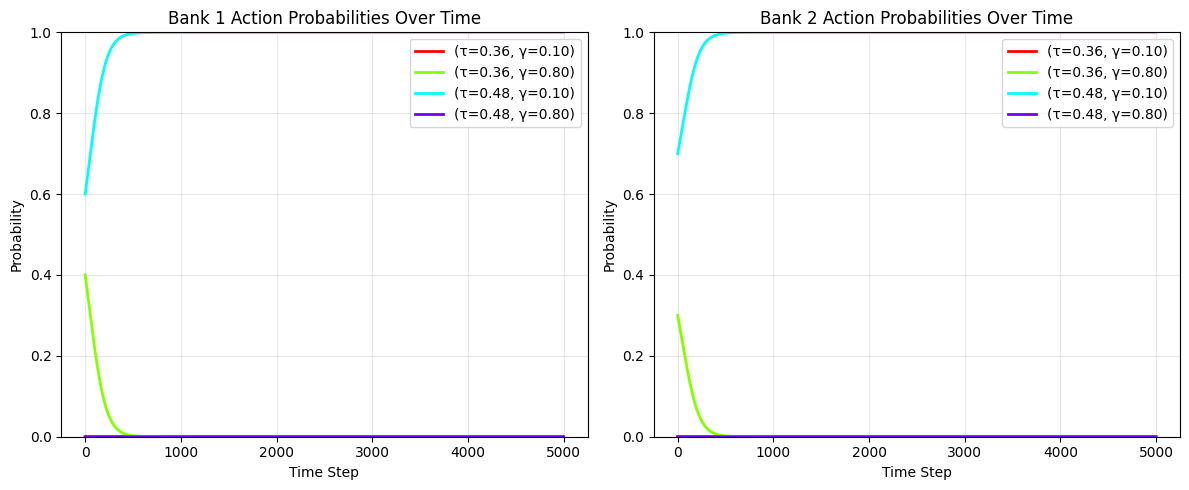

In [10]:
plot_game_probability_single((b1,b2,gammas,taus))

In [11]:
gfe = GameFreshEstimate(gammas=gammas, taus=taus, dist=tg, num_samples=1)

# run hedge on known matrix
T = 5000
eta = 0.1
p_b1 = np.array([0., 0.4, 0.6, 0.])
p_b2 = np.array([0., 0.3, 0.7, 0.])

b1,b2,gammas,taus = gfe.run_hedge(T=T, p_b1=p_b1, p_b2=p_b2, eta=eta)
print(b1[-1], b2[-1]) 
# last iterates for Bank1 and Bank2; We end up going to action 3 for both banks i.e. tau_h, gammaa_l
# symmetric pure NE

[0.0000000e+00 3.5672574e-27 1.0000000e+00 0.0000000e+00] [0.00000000e+00 2.84661719e-27 1.00000000e+00 0.00000000e+00]


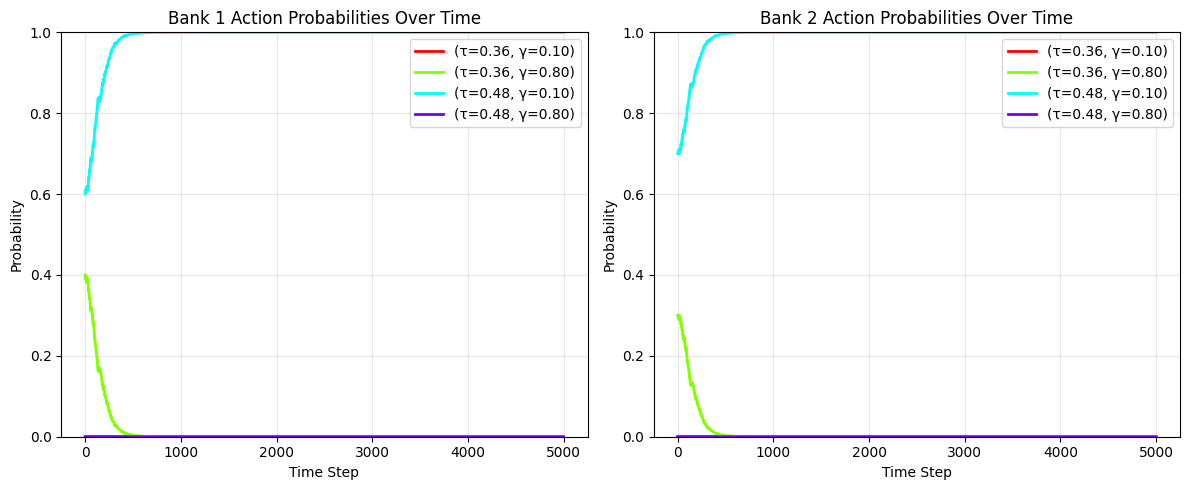

In [12]:
plot_game_probability_single((b1,b2,gammas,taus)) # also goes to the same pure symmetric NE, a bit noisy

In [13]:
gma = GameMovingAvg(gammas=gammas, taus=taus, dist=tg, num_samples=1)

# run hedge on known matrix
T = 5000
eta = 0.1
p_b1 = np.array([0., 0.4, 0.6, 0.])
p_b2 = np.array([0., 0.3, 0.7, 0.])

b1,b2,gammas,taus = gma.run_hedge(T=T, p_b1=p_b1, p_b2=p_b2, eta=eta)
print(b1[-1], b2[-1]) 
# last iterates for Bank1 and Bank2; We end up going to action 3 for both banks i.e. tau_h, gammaa_l
# symmetric pure NE

[0.00000000e+00 5.63423538e-28 1.00000000e+00 0.00000000e+00] [0.00000000e+00 4.40280126e-28 1.00000000e+00 0.00000000e+00]


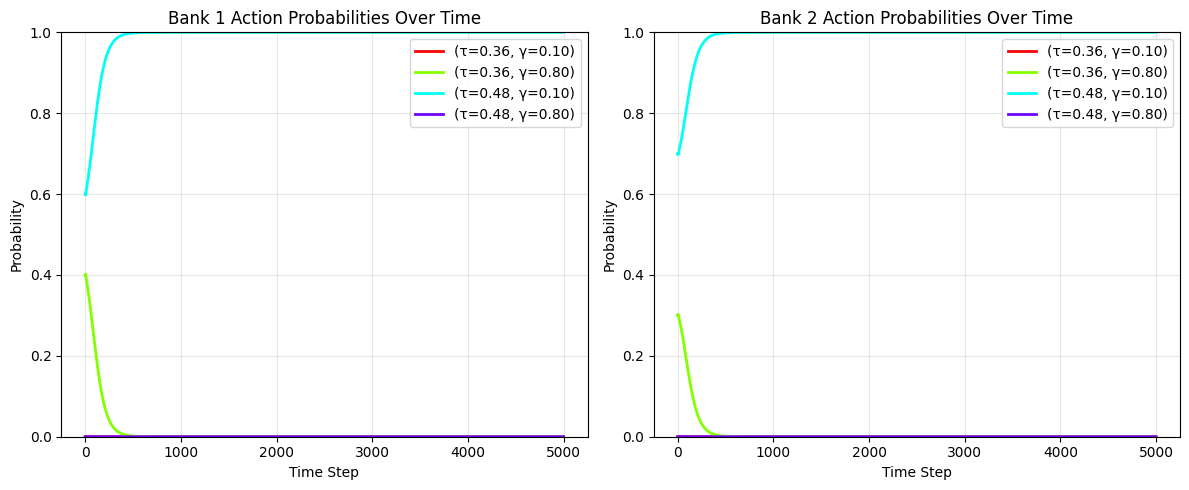

In [14]:
plot_game_probability_single((b1,b2,gammas,taus))

## Case 2 : epsilon_1 < 0, epsilon_2 > 0, 
## 3 NE - 2 pure, 1 mixed

## Using piecewise uniform here

In [15]:
gammas = sorted([0.3, 0.4])
taus = sorted([1/(2+gamma) for gamma in gammas])
puf = PiecewiseUniform(ga_l = gammas[0], ga_h = gammas[1]) #needs exactly these gamma_l and high values
gtm = GameTrueMatrix2by2(gammas=gammas, taus=taus, dist=puf)

gtm.eps1,gtm.eps2

(-0.001239131886514984, 0.007652173913043422)

In [16]:
display(len(gtm.NE_theory), gtm.NE_theory)

display(len(gtm.NE_se), gtm.NE_se)

3

[[[0, 1, 0, 0], [0, 0, 1, 0]],
 [[0, 0, 1, 0], [0, 1, 0, 0]],
 [[0, 0.8606356968215123, 0.1393643031784877, 0],
  [0, 0.8606356968215123, 0.1393643031784877, 0]]]

3

[(array([0., 1., 0., 0.]), array([0., 0., 1., 0.])),
 (array([0., 0., 1., 0.]), array([0., 1., 0., 0.])),
 (array([0.        , 0.86063556, 0.13936444, 0.        ]),
  array([0.        , 0.86063556, 0.13936444, 0.        ]))]

In [17]:
# run hedge on known matrix
T = 100000
eta = 0.1
p_b1 = np.array([0., 0.4, 0.6, 0.])
p_b2 = np.array([0., 0.3, 0.7, 0.])

b1,b2,gammas,taus = gtm.run_hedge(T=T, p_b1=p_b1, p_b2=p_b2, eta=eta)
print(b1[-1], b2[-1])
# Goes to assymetric Pure NE, (tau_l, gamma_h) for bank 1 and (tau_h, gamma_l) for bank2 as predicted in theory

[0.00000000e+00 1.00000000e+00 1.83577565e-29 0.00000000e+00] [0.00000000e+00 1.70851743e-05 9.99982915e-01 0.00000000e+00]


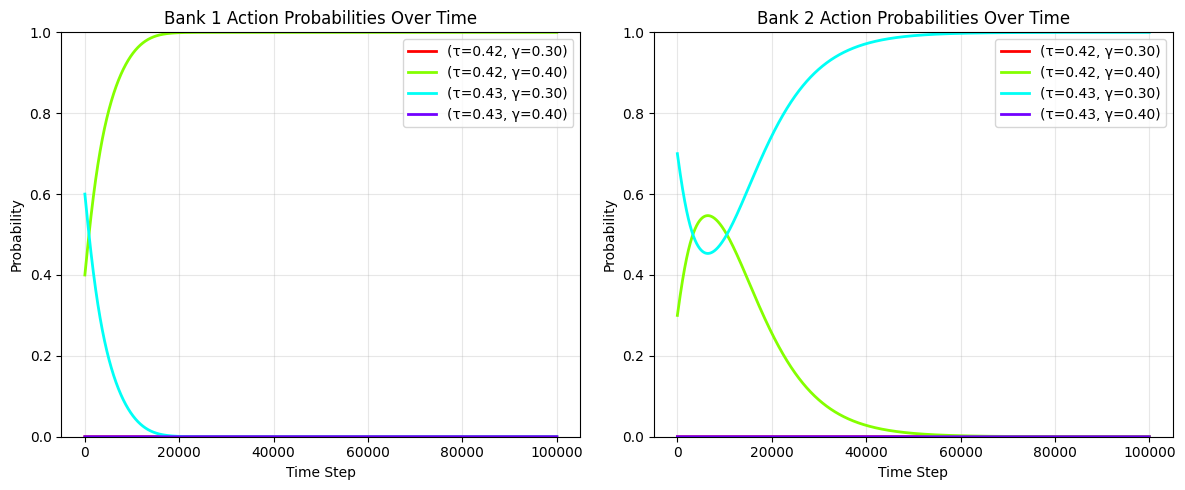

In [18]:
plot_game_probability_single((b1,b2,gammas,taus))

In [19]:
gfe = GameFreshEstimate(gammas=gammas, taus=taus, dist=puf, num_samples=1)

T = 100000
eta = 0.1
p_b1 = np.array([0., 0.4, 0.6, 0.])
p_b2 = np.array([0., 0.3, 0.7, 0.])

b1,b2,gammas,taus = gfe.run_hedge(T=T, p_b1=p_b1, p_b2=p_b2, eta=eta)
print(b1[-1], b2[-1]) 
# Goes to assymetric Pure NE, (tau_l, gamma_h) for bank 1 and (tau_h, gamma_l) for bank2 as predicted in theory

[0.00000000e+00 1.00000000e+00 1.90076143e-29 0.00000000e+00] [0.00000000e+00 3.19855470e-05 9.99968014e-01 0.00000000e+00]


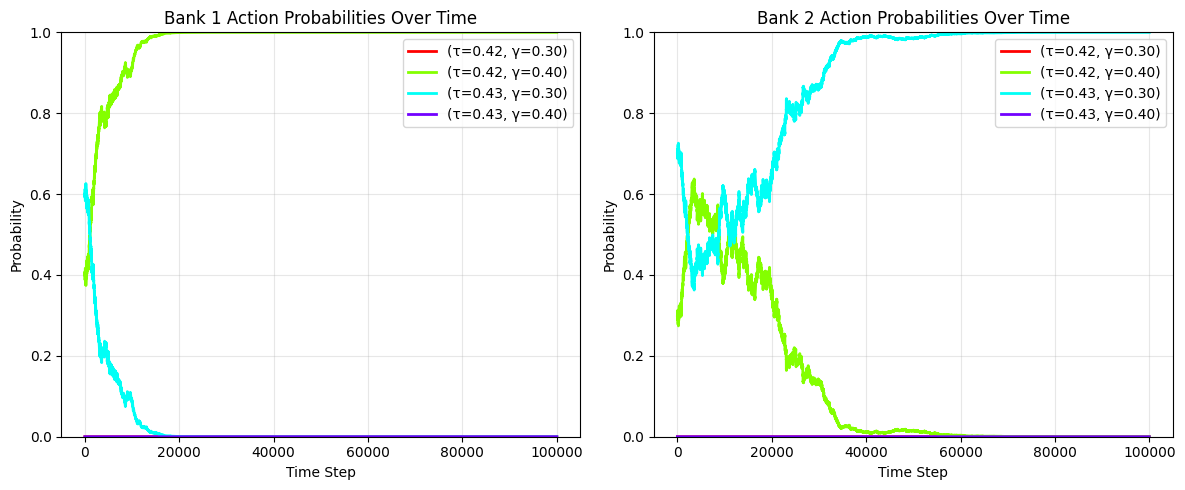

In [20]:
plot_game_probability_single((b1,b2,gammas,taus))

In [21]:
gfe = GameMovingAvg(gammas=gammas, taus=taus, dist=puf, num_samples=1)

T = 100000
eta = 0.1
p_b1 = np.array([0., 0.4, 0.6, 0.])
p_b2 = np.array([0., 0.3, 0.7, 0.])

b1,b2,gammas,taus = gfe.run_hedge(T=T, p_b1=p_b1, p_b2=p_b2, eta=eta)
print(b1[-1], b2[-1]) 
# Goes to assymetric Pure NE, (tau_l, gamma_h) for bank 1 and (tau_h, gamma_l) for bank2 as predicted in theory

[0.00000000e+00 1.00000000e+00 7.99225258e-32 0.00000000e+00] [0.00000000e+00 1.12694498e-04 9.99887306e-01 0.00000000e+00]


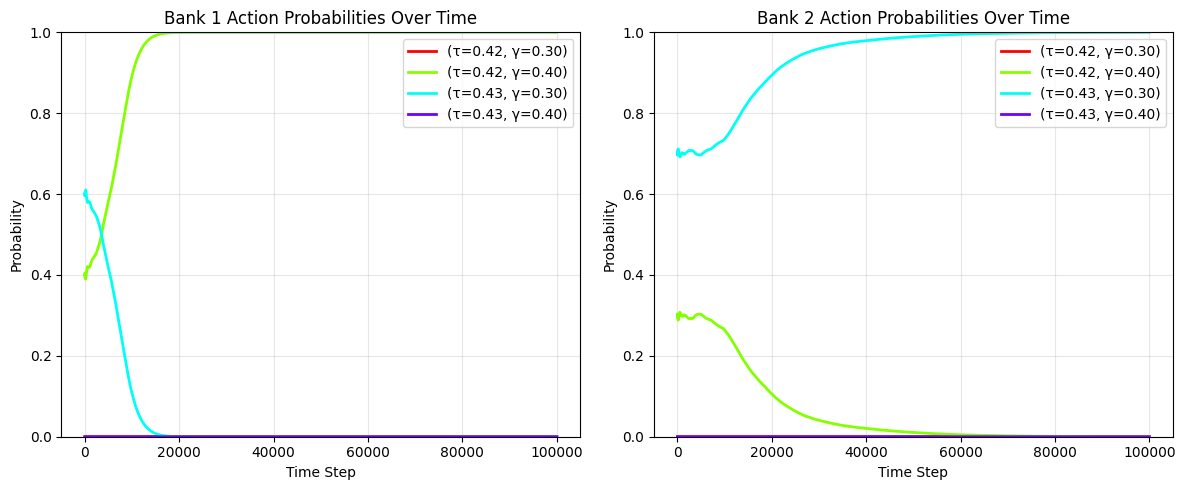

In [22]:
plot_game_probability_single((b1,b2,gammas,taus))

In [24]:
# Piecewise uniform sampling investigation
gammas = sorted([0.1, 0.6])
taus = sorted([1/(2+gamma) for gamma in gammas])
puf = PiecewiseUniform(ga_l = gammas[0], ga_h = gammas[1]) #needs exactly these gamma_l and high values
gtm = GameTrueMatrix2by2(gammas=gammas, taus=taus, dist=puf)
gtm.eps1, gtm.eps2

(0.052928571395602905, 0.10209523809523804)

In [25]:
taus[0], taus[1]

(0.3846153846153846, 0.47619047619047616)

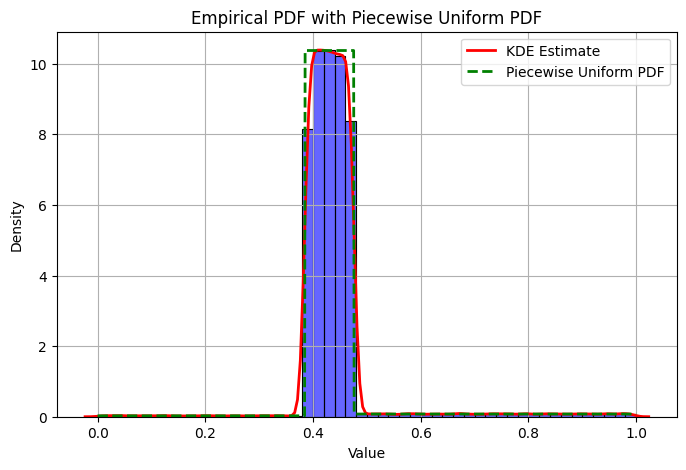

In [26]:
# @all ignore this block it was to check the sampling correctness with the actual probability, which is now fixed

def plot_empirical_pdf(samples, piecewise_uniform_pdf, tau_l, tau_h, bins=50, density=True):
    plt.figure(figsize=(8, 5))
    sns.histplot(samples, bins=bins, kde=False, stat="density", alpha=0.6, color='b', edgecolor='black')
    sns.kdeplot(samples, color='r', linewidth=2, label='KDE Estimate')
    
    # Plot piecewise uniform PDF
    
    y_values = np.linspace(0, 1, 1000)
    pdf_values = [piecewise_uniform_pdf(y, tau_l, tau_h) for y in y_values]
    plt.plot(y_values, pdf_values, color='g', linestyle='--', linewidth=2, label='Piecewise Uniform PDF') # true
    
    plt.xlabel('Value')
    plt.ylabel('Density')
    plt.title('Empirical PDF with Piecewise Uniform PDF')
    plt.legend()
    plt.grid(True)
    plt.show()

# Define piecewise uniform PDF function
def piecewise_uniform_pdf(y, tau_l, tau_h):
    if 0 <= y < tau_l:
        return 0.01 / tau_l
    elif tau_l <= y < tau_h:
        return 0.95 / (tau_h - tau_l)
    elif tau_h <= y <= 1:
        return 0.04 / (1 - tau_h)
    else:
        return 0

gammas = sorted([0.1, 0.6])
taus = sorted([1/(2+gamma) for gamma in gammas])
puf = PiecewiseUniform(ga_l = gammas[0], ga_h = gammas[1]) #needs exactly these gamma_l and high values
gtm = GameTrueMatrix2by2(gammas=gammas, taus=taus, dist=puf)

tau_l, tau_h = taus
samples = puf.get_samples(100000)

      
# Assuming arr contains the samples
plot_empirical_pdf(samples, piecewise_uniform_pdf, tau_l, tau_h)

## Case 3: epsilon_1 < 0, epsilon_2 < 0

## Single Pure NE, symmetric (tau_h, gamma_l)

# using trungauss here

In [27]:
gammas = sorted([0.4, 0.8])
taus = sorted([1/(2+gamma) for gamma in gammas])
mu = 0.6
sigma = 0.2
tg = TruncatedGaussian(mu = mu, sigma = sigma)
gtm = GameTrueMatrix2by2(gammas=gammas, taus=taus, dist=tg)
print(gtm.eps1, gtm.eps2) # epsilon1<0 and epsilon2<0

-0.12134951137879574 -0.2249271215325935


In [28]:
display(len(gtm.NE_theory), gtm.NE_theory)

display(len(gtm.NE_se), gtm.NE_se)

1

[[[0, 0, 1, 0], [0, 0, 1, 0]]]

1

[(array([0., 0., 1., 0.]), array([0., 0., 1., 0.]))]

In [29]:
# run hedge on known matrix
T = 5000
eta = 0.1
p_b1 = np.array([0., 0.4, 0.6, 0.])
p_b2 = np.array([0., 0.3, 0.7, 0.])

b1,b2,gammas,taus = gtm.run_hedge(T=T, p_b1=p_b1, p_b2=p_b2, eta=eta)
print(b1[-1], b2[-1]) 
# last iterates for Bank1 and Bank2; We end up going to action 3 for both banks i.e. tau_h, gammaa_l
# symmetric pure NE

[0.00000000e+00 1.15321507e-49 1.00000000e+00 0.00000000e+00] [0.00000000e+00 7.96310351e-50 1.00000000e+00 0.00000000e+00]


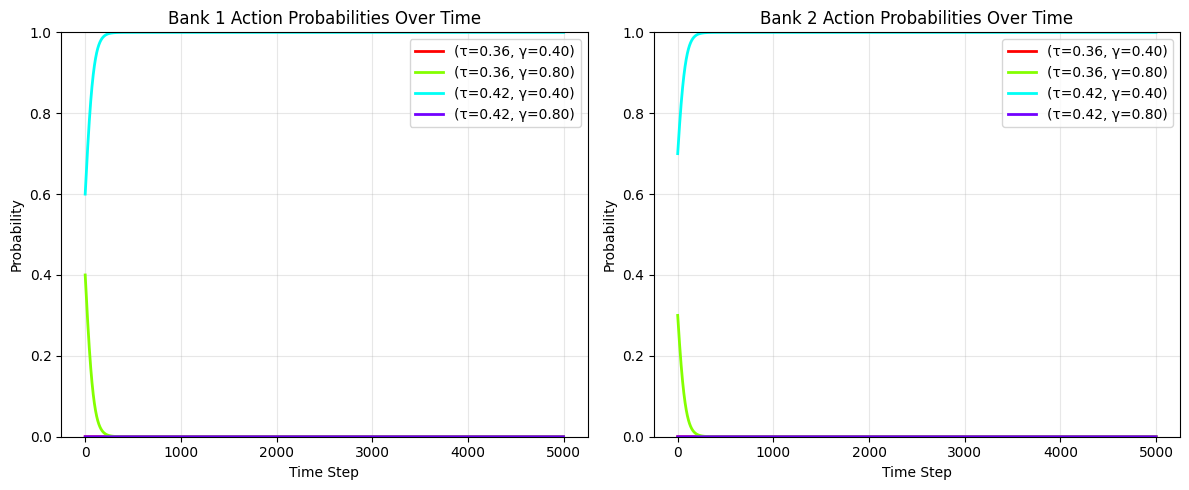

In [30]:
plot_game_probability_single((b1,b2,gammas,taus))

In [31]:
gfe = GameFreshEstimate(gammas=gammas, taus=taus, dist=tg, num_samples=1)

# run hedge on known matrix
T = 5000
eta = 0.1
p_b1 = np.array([0., 0.4, 0.6, 0.])
p_b2 = np.array([0., 0.3, 0.7, 0.])

b1,b2,gammas,taus = gfe.run_hedge(T=T, p_b1=p_b1, p_b2=p_b2, eta=eta)
print(b1[-1], b2[-1]) 
# last iterates for Bank1 and Bank2; We end up going to action 3 for both banks i.e. tau_h, gammaa_l# last iterates for Bank1 and Bank2; We end up going to action 3 for both banks i.e. tau_h, gammaa_l
# symmetric pure NE

[0.00000000e+00 9.70547357e-50 1.00000000e+00 0.00000000e+00] [0.000000e+00 6.675098e-50 1.000000e+00 0.000000e+00]


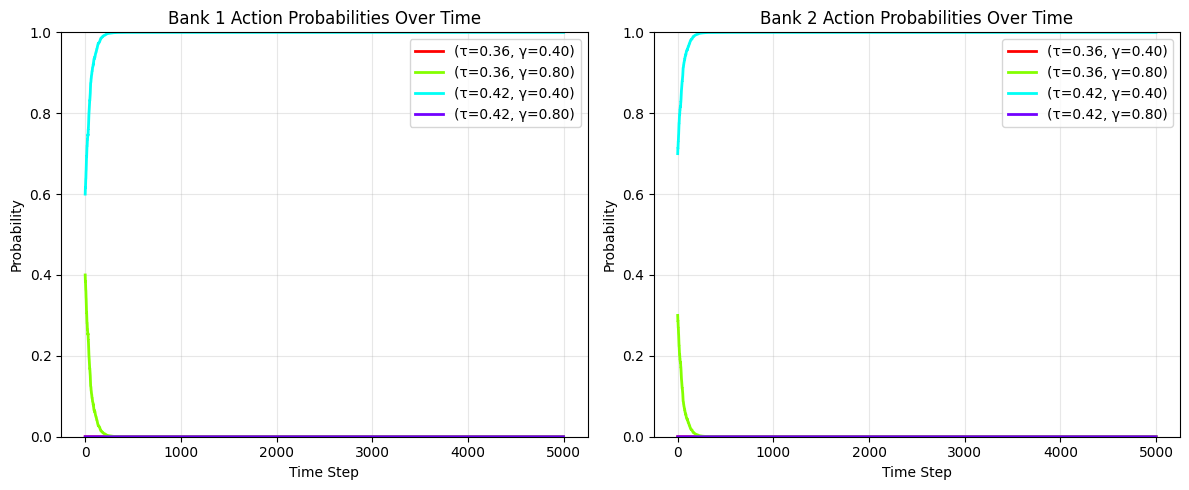

In [32]:
plot_game_probability_single((b1,b2,gammas,taus))

In [33]:
gma = GameMovingAvg(gammas=gammas, taus=taus, dist=tg, num_samples=1)

# run hedge on known matrix
T = 5000
eta = 0.1
p_b1 = np.array([0., 0.4, 0.6, 0.])
p_b2 = np.array([0., 0.3, 0.7, 0.])

b1,b2,gammas,taus = gma.run_hedge(T=T, p_b1=p_b1, p_b2=p_b2, eta=eta)
print(b1[-1], b2[-1]) 
# last iterates for Bank1 and Bank2; We end up going to action 3 for both banks i.e. tau_h, gammaa_l

[0.0000000e+00 1.3110232e-49 1.0000000e+00 0.0000000e+00] [0.00000000e+00 9.11568265e-50 1.00000000e+00 0.00000000e+00]


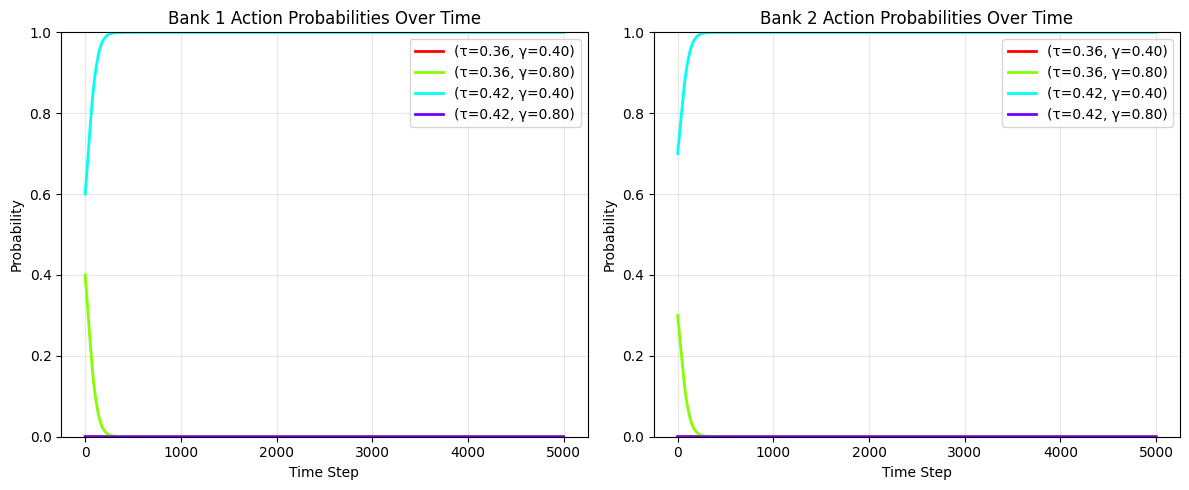

In [34]:
plot_game_probability_single((b1,b2,gammas,taus))

## Case 4: epsilon_1 > 0, epsilon_2 > 0

## Single Pure NE, symmetric (tau_l, gamma_h)

In [36]:
gammas = sorted([0.1, 0.5])
taus = sorted([1/(2+gamma) for gamma in gammas])
puf = PiecewiseUniform(ga_l = gammas[0], ga_h = gammas[1]) #needs exactly these gamma_l and high values
gtm = GameTrueMatrix2by2(gammas=[0.1, 0.5], taus=taus, dist=puf)

gtm.eps1,gtm.eps2

(0.04014285742558564, 0.07947619047619046)

In [37]:
display(len(gtm.NE_se), gtm.NE_se) # 1 pure NE only in the one shot game
display(len(gtm.NE_theory), gtm.NE_theory)

1

[(array([0., 1., 0., 0.]), array([0., 1., 0., 0.]))]

1

[[[0, 1, 0, 0], [0, 1, 0, 0]]]

In [38]:
# run hedge on known matrix
T = 5000
eta = 0.1
p_b1 = np.array([0., 0.4, 0.6, 0.])
p_b2 = np.array([0., 0.3, 0.7, 0.])

b1,b2,gammas,taus = gtm.run_hedge(T=T, p_b1=p_b1, p_b2=p_b2, eta=eta)
print(b1[-1], b2[-1]) 
# last iterates for Bank1 and Bank2; We end up going to action 3 for both banks i.e. tau_h, gammaa_l

[0.00000000e+00 9.99999999e-01 1.14994390e-09 0.00000000e+00] [0.00000000e+00 9.99999998e-01 2.37146053e-09 0.00000000e+00]


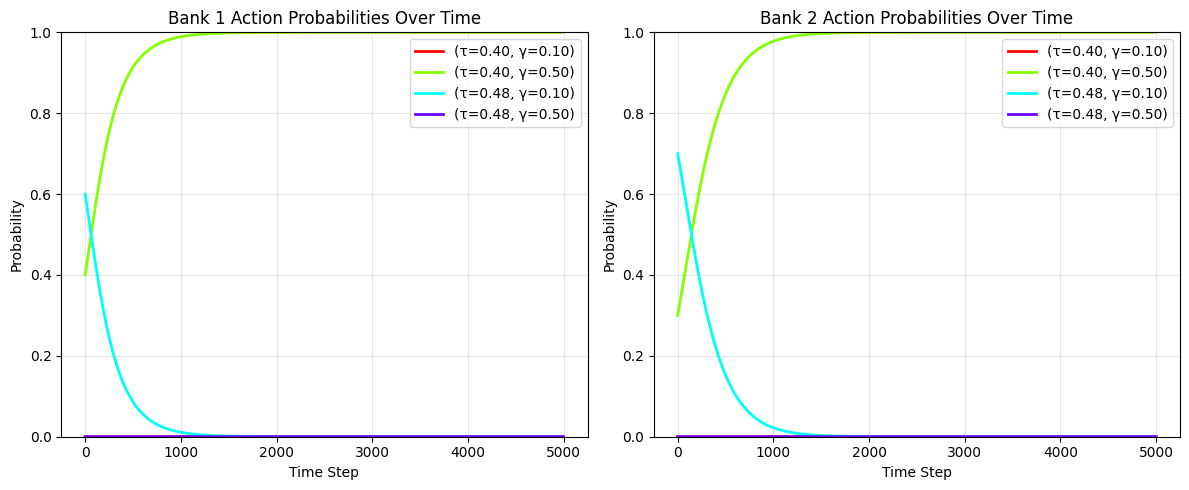

In [39]:
plot_game_probability_single((b1,b2,gammas,taus))

In [40]:
gfe = GameFreshEstimate(gammas=gammas, taus=taus, dist=puf, num_samples=1)

# run hedge on known matrix
T = 5000
eta = 0.1
p_b1 = np.array([0., 0.4, 0.6, 0.])
p_b2 = np.array([0., 0.3, 0.7, 0.])

b1,b2,gammas,taus = gfe.run_hedge(T=T, p_b1=p_b1, p_b2=p_b2, eta=eta)
print(b1[-1], b2[-1]) 
# last iterates for Bank1 and Bank2; We end up going to action 3 for both banks i.e. tau_h, gammaa_l

[0.00000000e+00 9.99999999e-01 1.48528003e-09 0.00000000e+00] [0.00000000e+00 9.99999997e-01 3.07303246e-09 0.00000000e+00]


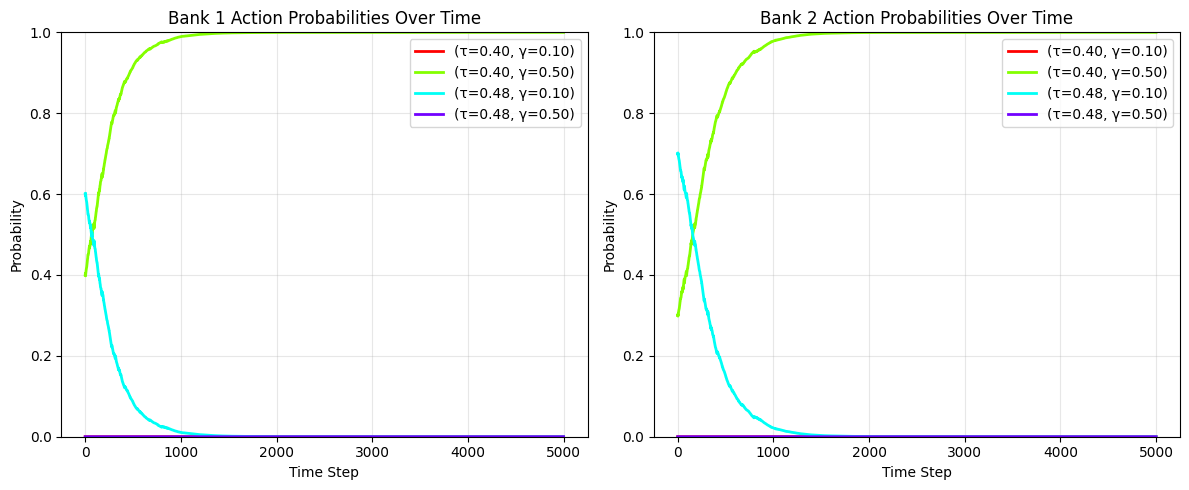

In [41]:
plot_game_probability_single((b1,b2,gammas,taus))

In [42]:
gma = GameMovingAvg(gammas=gammas, taus=taus, dist=puf, num_samples=1)

# run hedge on known matrix
T = 5000
eta = 0.1
p_b1 = np.array([0., 0.4, 0.6, 0.])
p_b2 = np.array([0., 0.3, 0.7, 0.])


b1,b2,gammas,taus = gma.run_hedge(T=T, p_b1=p_b1, p_b2=p_b2, eta=eta)
print(b1[-1], b2[-1]) 
# last iterates for Bank1 and Bank2; We end up going to action 3 for both banks i.e. tau_h, gammaa_l

[0.00000000e+00 9.99999997e-01 3.05715906e-09 0.00000000e+00] [0.00000000e+00 9.99999994e-01 6.31607545e-09 0.00000000e+00]


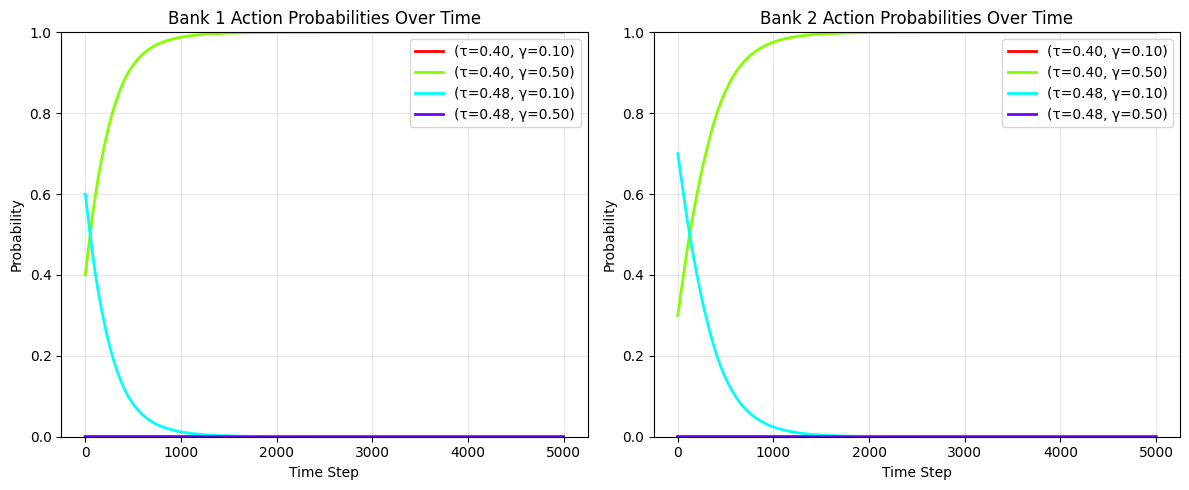

In [43]:
plot_game_probability_single((b1,b2,gammas,taus))